In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(1)
epochs = 90
batch_size = 512
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
            
        tmp = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(tmp)
                tmp = list()
            else:
                tmp.append(i)
        y.append(label_list)
    return [x, y]

In [5]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [6]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [7]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [8]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [9]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [10]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [11]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76508
76508


In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48964 48964
12242 12242
15302 15302


In [13]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-12 14:12:31,185 [DEBUG] kashgari - ------------------------------------------------
2020-12-12 14:12:31,185 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-12 14:12:31,186 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-12 14:12:31,186 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-12 14:12:31,186 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-12 14:12:31,187 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/90
95/95 [==============================] - 36s 384ms/step - loss: 1.2058 - accuracy: 0.9506 - val_loss: 27.2263 - val_accuracy: 0.6166
Epoch 2/90
95/95 [==============================] - 34s 354ms/step - loss: 0.3264 - accuracy: 0.9820 - val_loss: 27.1150 - val_accuracy: 0.8909
Epoch 3/90
95/95 [==============================] - 34s 356ms/step - loss: 0.2373 - accuracy: 0.9855 - val_loss: 26.9670 - val_accuracy: 0.9880
Epoch 4/90
95/95 [==============================] - 34s 358ms/step - loss: 0.1963 - accuracy: 0.9876 - val_loss: 26.9130 - val_accuracy: 0.9889
Epoch 5/90
95/95 [==============================] - 34s 359ms/step - loss: 0.1713 - accuracy: 0.9890 - val_loss: 26.7950 - val_accuracy: 0.9900
Epoch 6/90
95/95 [==============================] - 34s 361ms/step - loss: 0.1527 - accuracy: 0.9897 - val_loss: 26.6773 - val_accuracy: 0.9905
Epoch 7/90
95/95 [==============================] - 34s 363ms/step - loss: 0.1382 - accuracy: 0.9904 - val_loss: 26.5975 - val_accuracy:

95/95 [==============================] - 34s 361ms/step - loss: 0.0129 - accuracy: 0.9986 - val_loss: 23.7250 - val_accuracy: 0.0188
Epoch 58/90
95/95 [==============================] - 34s 361ms/step - loss: 0.0122 - accuracy: 0.9987 - val_loss: 23.6101 - val_accuracy: 0.0185
Epoch 59/90
95/95 [==============================] - 34s 361ms/step - loss: 0.0127 - accuracy: 0.9985 - val_loss: 23.6044 - val_accuracy: 0.0172
Epoch 60/90
95/95 [==============================] - 34s 361ms/step - loss: 0.0116 - accuracy: 0.9988 - val_loss: 23.5428 - val_accuracy: 0.0174
Epoch 61/90
95/95 [==============================] - 34s 360ms/step - loss: 0.0116 - accuracy: 0.9987 - val_loss: 23.5174 - val_accuracy: 0.0177
Epoch 62/90
95/95 [==============================] - 34s 361ms/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 23.4255 - val_accuracy: 0.0176
Epoch 63/90
95/95 [==============================] - 34s 361ms/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 23.3965 - val_accuracy: 0.01

In [14]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-12 15:04:48,501 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-12 15:04:48,587 [DEBUG] kashgari - predict seq_length: None, input: (2, 15302, 72)


479/479 [==============================] - 41s 86ms/step


2020-12-12 15:05:33,206 [DEBUG] kashgari - predict output: (15302, 72)
2020-12-12 15:05:33,207 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.8268    0.8726    0.8491       848
          name     0.9362    0.8800    0.9072       100
      med_exam     0.8451    0.8571    0.8511       140
      location     0.8889    0.8791    0.8840        91
         money     0.7077    0.8846    0.7863        52
clinical_event     1.0000    0.2500    0.4000         4
        family     1.0000    0.7059    0.8276        17
    profession     0.8000    0.4444    0.5714         9
  organization     1.0000    0.3333    0.5000         3
            ID     0.6667    0.5000    0.5714         8
       contact     0.6667    0.6154    0.6400        13
     education     0.0000    0.0000    0.0000         1

     micro avg     0.8345    0.8585    0.8463      1286
     macro avg     0.8367    0.8585    0.8448      1286



2020-12-12 15:05:42,536 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-90


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-90'

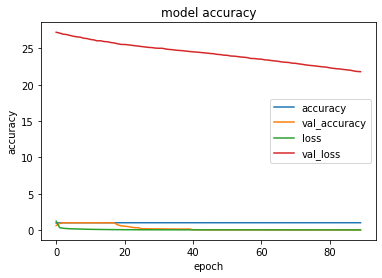

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [16]:
# def predict_NER(model, text, sequence_length):
#     x_list = list()
#     while len(text) > sequence_length:
#         x_list.append([i for i in text[:sequence_length]])
#         text = text[sequence_length:]        
#     x_list.append([i for i in text[:sequence_length]])
#     y_list = model.predict(x_list)
#     merge_list = list()
#     for i in y_list:
#         for j in i:
#             merge_list.append(j)
#     return merge_list

In [17]:
# def output_NER(article_id, text, y):
#     output = str()
#     flag = False
#     for i, j in enumerate(y):
#         if j != 'O':
#             if j[0] == 'B':
#                 start_position = i
#                 entity_type = j.split('-')[-1]
#                 flag = True
#         elif j == 'O' and flag == True:
#             end_position = i
#             flag = False
#             entity_text = text[start_position: end_position]
#             output += '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
#     return output

In [18]:
# for article_id, text in zip(df['article_id'], df['text']):
#     y = predict_NER(model, text, sequence_length)
#     output += output_NER(article_id, text, y)

In [19]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-12 15:05:42,685 [DEBUG] kashgari - predict seq_length: None, input: (2, 368, 29)


12/12 [==============================] - 0s 40ms/step


2020-12-12 15:05:46,214 [DEBUG] kashgari - predict output: (368, 29)
2020-12-12 15:05:46,215 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:05:46,216 [DEBUG] kashgari - predict seq_length: None, input: (2, 78, 33)


3/3 [==============================] - 0s 30ms/step


2020-12-12 15:05:49,135 [DEBUG] kashgari - predict output: (78, 33)
2020-12-12 15:05:49,135 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-12 15:05:49,138 [DEBUG] kashgari - predict seq_length: None, input: (2, 159, 29)


5/5 [==============================] - 0s 34ms/step


2020-12-12 15:05:49,383 [DEBUG] kashgari - predict output: (159, 29)
2020-12-12 15:05:49,384 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:05:49,389 [DEBUG] kashgari - predict seq_length: None, input: (2, 329, 28)


11/11 [==============================] - 0s 38ms/step


2020-12-12 15:05:52,639 [DEBUG] kashgari - predict output: (329, 28)
2020-12-12 15:05:52,640 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:05:52,644 [DEBUG] kashgari - predict seq_length: None, input: (2, 227, 29)


8/8 [==============================] - 0s 34ms/step


2020-12-12 15:05:52,982 [DEBUG] kashgari - predict output: (227, 29)
2020-12-12 15:05:52,982 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:05:52,987 [DEBUG] kashgari - predict seq_length: None, input: (2, 295, 26)


10/10 [==============================] - 0s 36ms/step


2020-12-12 15:05:56,226 [DEBUG] kashgari - predict output: (295, 26)
2020-12-12 15:05:56,227 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:05:56,229 [DEBUG] kashgari - predict seq_length: None, input: (2, 183, 25)


6/6 [==============================] - 0s 34ms/step


2020-12-12 15:05:59,557 [DEBUG] kashgari - predict output: (183, 25)
2020-12-12 15:05:59,558 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1 13 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 15:05:59,561 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 19)


4/4 [==============================] - 0s 27ms/step


2020-12-12 15:06:02,506 [DEBUG] kashgari - predict output: (126, 19)
2020-12-12 15:06:02,506 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:02,509 [DEBUG] kashgari - predict seq_length: None, input: (2, 117, 23)


4/4 [==============================] - 0s 30ms/step


2020-12-12 15:06:05,525 [DEBUG] kashgari - predict output: (117, 23)
2020-12-12 15:06:05,525 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:05,527 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 22)


3/3 [==============================] - 0s 24ms/step


2020-12-12 15:06:08,447 [DEBUG] kashgari - predict output: (91, 22)
2020-12-12 15:06:08,448 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:08,450 [DEBUG] kashgari - predict seq_length: None, input: (2, 63, 25)


2/2 [==============================] - 0s 22ms/step


2020-12-12 15:06:08,558 [DEBUG] kashgari - predict output: (63, 25)
2020-12-12 15:06:08,559 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:08,564 [DEBUG] kashgari - predict seq_length: None, input: (2, 259, 32)


9/9 [==============================] - 0s 40ms/step


2020-12-12 15:06:12,099 [DEBUG] kashgari - predict output: (259, 32)
2020-12-12 15:06:12,100 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  7  7  7]
 [ 0  1  1 ...  1  1  1]
 [ 0 10  7 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 15:06:12,103 [DEBUG] kashgari - predict seq_length: None, input: (2, 109, 20)


4/4 [==============================] - 0s 25ms/step


2020-12-12 15:06:15,018 [DEBUG] kashgari - predict output: (109, 20)
2020-12-12 15:06:15,019 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:15,022 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 22)


4/4 [==============================] - 0s 27ms/step


2020-12-12 15:06:15,189 [DEBUG] kashgari - predict output: (122, 22)
2020-12-12 15:06:15,190 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:15,193 [DEBUG] kashgari - predict seq_length: None, input: (2, 158, 40)


5/5 [==============================] - 0s 46ms/step


2020-12-12 15:06:18,276 [DEBUG] kashgari - predict output: (158, 40)
2020-12-12 15:06:18,276 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]]
2020-12-12 15:06:18,281 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 34)


7/7 [==============================] - 0s 43ms/step


2020-12-12 15:06:21,435 [DEBUG] kashgari - predict output: (218, 34)
2020-12-12 15:06:21,436 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:21,439 [DEBUG] kashgari - predict seq_length: None, input: (2, 103, 16)


4/4 [==============================] - 0s 22ms/step


2020-12-12 15:06:24,340 [DEBUG] kashgari - predict output: (103, 16)
2020-12-12 15:06:24,341 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]]
2020-12-12 15:06:24,346 [DEBUG] kashgari - predict seq_length: None, input: (2, 310, 40)


10/10 [==============================] - 0s 47ms/step


2020-12-12 15:06:24,896 [DEBUG] kashgari - predict output: (310, 40)
2020-12-12 15:06:24,897 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:24,899 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 22)


3/3 [==============================] - 0s 19ms/step


2020-12-12 15:06:25,011 [DEBUG] kashgari - predict output: (73, 22)
2020-12-12 15:06:25,012 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 6 4 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:25,020 [DEBUG] kashgari - predict seq_length: None, input: (2, 624, 50)


20/20 [==============================] - 1s 60ms/step


2020-12-12 15:06:29,085 [DEBUG] kashgari - predict output: (624, 50)
2020-12-12 15:06:29,086 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:29,091 [DEBUG] kashgari - predict seq_length: None, input: (2, 445, 35)


14/14 [==============================] - 1s 46ms/step


2020-12-12 15:06:33,075 [DEBUG] kashgari - predict output: (445, 35)
2020-12-12 15:06:33,075 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 6 ... 4 4 4]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:33,079 [DEBUG] kashgari - predict seq_length: None, input: (2, 357, 34)


12/12 [==============================] - 0s 41ms/step


2020-12-12 15:06:33,638 [DEBUG] kashgari - predict output: (357, 34)
2020-12-12 15:06:33,639 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:33,642 [DEBUG] kashgari - predict seq_length: None, input: (2, 328, 49)


11/11 [==============================] - 1s 57ms/step


2020-12-12 15:06:36,969 [DEBUG] kashgari - predict output: (328, 49)
2020-12-12 15:06:36,970 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:36,972 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 59)


5/5 [==============================] - 0s 55ms/step


2020-12-12 15:06:40,148 [DEBUG] kashgari - predict output: (133, 59)
2020-12-12 15:06:40,149 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:40,151 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 23)


5/5 [==============================] - 0s 28ms/step


2020-12-12 15:06:40,346 [DEBUG] kashgari - predict output: (129, 23)
2020-12-12 15:06:40,347 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:40,350 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 30)


5/5 [==============================] - 0s 33ms/step


2020-12-12 15:06:43,379 [DEBUG] kashgari - predict output: (131, 30)
2020-12-12 15:06:43,380 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 6 4 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:43,384 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 34)


8/8 [==============================] - 0s 39ms/step


2020-12-12 15:06:43,767 [DEBUG] kashgari - predict output: (234, 34)
2020-12-12 15:06:43,768 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:43,770 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 33)


3/3 [==============================] - 0s 27ms/step


2020-12-12 15:06:43,916 [DEBUG] kashgari - predict output: (79, 33)
2020-12-12 15:06:43,917 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:43,921 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 37)


9/9 [==============================] - 0s 44ms/step


2020-12-12 15:06:47,024 [DEBUG] kashgari - predict output: (260, 37)
2020-12-12 15:06:47,025 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:47,027 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 35)


8/8 [==============================] - 0s 40ms/step


2020-12-12 15:06:47,419 [DEBUG] kashgari - predict output: (255, 35)
2020-12-12 15:06:47,420 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:47,422 [DEBUG] kashgari - predict seq_length: None, input: (2, 175, 41)


6/6 [==============================] - 0s 46ms/step


2020-12-12 15:06:50,560 [DEBUG] kashgari - predict output: (175, 41)
2020-12-12 15:06:50,561 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:50,564 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 31)


6/6 [==============================] - 0s 41ms/step


2020-12-12 15:06:53,690 [DEBUG] kashgari - predict output: (189, 31)
2020-12-12 15:06:53,691 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:53,694 [DEBUG] kashgari - predict seq_length: None, input: (2, 292, 31)


10/10 [==============================] - 0s 37ms/step


2020-12-12 15:06:54,134 [DEBUG] kashgari - predict output: (292, 31)
2020-12-12 15:06:54,135 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:54,136 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 38)


4/4 [==============================] - 0s 36ms/step


2020-12-12 15:06:57,739 [DEBUG] kashgari - predict output: (97, 38)
2020-12-12 15:06:57,739 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:06:57,745 [DEBUG] kashgari - predict seq_length: None, input: (2, 351, 56)


11/11 [==============================] - 1s 63ms/step


2020-12-12 15:07:01,330 [DEBUG] kashgari - predict output: (351, 56)
2020-12-12 15:07:01,331 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:01,335 [DEBUG] kashgari - predict seq_length: None, input: (2, 297, 46)


10/10 [==============================] - 1s 55ms/step


2020-12-12 15:07:04,770 [DEBUG] kashgari - predict output: (297, 46)
2020-12-12 15:07:04,770 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:04,773 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 21)


5/5 [==============================] - 0s 28ms/step


2020-12-12 15:07:07,744 [DEBUG] kashgari - predict output: (136, 21)
2020-12-12 15:07:07,745 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:07,748 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 42)


4/4 [==============================] - 0s 41ms/step


2020-12-12 15:07:10,771 [DEBUG] kashgari - predict output: (115, 42)
2020-12-12 15:07:10,771 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:10,774 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 23)


3/3 [==============================] - 0s 23ms/step


2020-12-12 15:07:10,909 [DEBUG] kashgari - predict output: (89, 23)
2020-12-12 15:07:10,910 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:10,915 [DEBUG] kashgari - predict seq_length: None, input: (2, 251, 52)


8/8 [==============================] - 0s 59ms/step


2020-12-12 15:07:14,259 [DEBUG] kashgari - predict output: (251, 52)
2020-12-12 15:07:14,260 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:14,263 [DEBUG] kashgari - predict seq_length: None, input: (2, 153, 20)


5/5 [==============================] - 0s 26ms/step


2020-12-12 15:07:14,446 [DEBUG] kashgari - predict output: (153, 20)
2020-12-12 15:07:14,447 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  1  1 ... 25 25 25]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 15:07:14,451 [DEBUG] kashgari - predict seq_length: None, input: (2, 169, 47)


6/6 [==============================] - 0s 54ms/step


2020-12-12 15:07:17,503 [DEBUG] kashgari - predict output: (169, 47)
2020-12-12 15:07:17,504 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:17,507 [DEBUG] kashgari - predict seq_length: None, input: (2, 324, 37)


11/11 [==============================] - 0s 44ms/step


2020-12-12 15:07:18,065 [DEBUG] kashgari - predict output: (324, 37)
2020-12-12 15:07:18,066 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:18,068 [DEBUG] kashgari - predict seq_length: None, input: (2, 157, 35)


5/5 [==============================] - 0s 37ms/step


2020-12-12 15:07:18,321 [DEBUG] kashgari - predict output: (157, 35)
2020-12-12 15:07:18,322 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:18,325 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 27)


6/6 [==============================] - 0s 38ms/step


2020-12-12 15:07:21,391 [DEBUG] kashgari - predict output: (191, 27)
2020-12-12 15:07:21,392 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:21,394 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 36)


4/4 [==============================] - 0s 38ms/step


2020-12-12 15:07:24,410 [DEBUG] kashgari - predict output: (115, 36)
2020-12-12 15:07:24,411 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:24,418 [DEBUG] kashgari - predict seq_length: None, input: (2, 529, 33)


17/17 [==============================] - 1s 42ms/step


2020-12-12 15:07:25,205 [DEBUG] kashgari - predict output: (529, 33)
2020-12-12 15:07:25,205 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:25,208 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 32)


7/7 [==============================] - 0s 37ms/step


2020-12-12 15:07:25,535 [DEBUG] kashgari - predict output: (217, 32)
2020-12-12 15:07:25,536 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:25,538 [DEBUG] kashgari - predict seq_length: None, input: (2, 186, 47)


6/6 [==============================] - 0s 50ms/step


2020-12-12 15:07:25,924 [DEBUG] kashgari - predict output: (186, 47)
2020-12-12 15:07:25,925 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:25,931 [DEBUG] kashgari - predict seq_length: None, input: (2, 410, 55)


13/13 [==============================] - 1s 64ms/step


2020-12-12 15:07:30,386 [DEBUG] kashgari - predict output: (410, 55)
2020-12-12 15:07:30,386 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:30,390 [DEBUG] kashgari - predict seq_length: None, input: (2, 347, 42)


11/11 [==============================] - 1s 48ms/step


2020-12-12 15:07:30,996 [DEBUG] kashgari - predict output: (347, 42)
2020-12-12 15:07:30,997 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:31,003 [DEBUG] kashgari - predict seq_length: None, input: (2, 524, 65)


17/17 [==============================] - 1s 74ms/step


2020-12-12 15:07:35,165 [DEBUG] kashgari - predict output: (524, 65)
2020-12-12 15:07:35,166 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:35,169 [DEBUG] kashgari - predict seq_length: None, input: (2, 182, 29)


6/6 [==============================] - 0s 33ms/step


2020-12-12 15:07:35,430 [DEBUG] kashgari - predict output: (182, 29)
2020-12-12 15:07:35,431 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:35,433 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 20)


6/6 [==============================] - 0s 26ms/step


2020-12-12 15:07:35,640 [DEBUG] kashgari - predict output: (163, 20)
2020-12-12 15:07:35,641 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:35,643 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 19)


4/4 [==============================] - 0s 21ms/step


2020-12-12 15:07:35,782 [DEBUG] kashgari - predict output: (97, 19)
2020-12-12 15:07:35,783 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:35,786 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 21)


6/6 [==============================] - 0s 28ms/step


2020-12-12 15:07:36,006 [DEBUG] kashgari - predict output: (189, 21)
2020-12-12 15:07:36,007 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:36,013 [DEBUG] kashgari - predict seq_length: None, input: (2, 320, 25)


10/10 [==============================] - 0s 29ms/step


2020-12-12 15:07:38,333 [DEBUG] kashgari - predict output: (320, 25)
2020-12-12 15:07:38,334 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:38,338 [DEBUG] kashgari - predict seq_length: None, input: (2, 301, 20)


10/10 [==============================] - 0s 29ms/step


2020-12-12 15:07:38,686 [DEBUG] kashgari - predict output: (301, 20)
2020-12-12 15:07:38,686 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:38,688 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 35)


3/3 [==============================] - 0s 28ms/step


2020-12-12 15:07:38,837 [DEBUG] kashgari - predict output: (82, 35)
2020-12-12 15:07:38,837 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:38,841 [DEBUG] kashgari - predict seq_length: None, input: (2, 192, 37)


6/6 [==============================] - 0s 37ms/step


2020-12-12 15:07:41,126 [DEBUG] kashgari - predict output: (192, 37)
2020-12-12 15:07:41,126 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 6 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:41,131 [DEBUG] kashgari - predict seq_length: None, input: (2, 264, 48)


9/9 [==============================] - 0s 54ms/step


2020-12-12 15:07:44,515 [DEBUG] kashgari - predict output: (264, 48)
2020-12-12 15:07:44,516 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:44,519 [DEBUG] kashgari - predict seq_length: None, input: (2, 247, 43)


8/8 [==============================] - 0s 50ms/step


2020-12-12 15:07:47,780 [DEBUG] kashgari - predict output: (247, 43)
2020-12-12 15:07:47,781 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:47,782 [DEBUG] kashgari - predict seq_length: None, input: (2, 120, 21)


4/4 [==============================] - 0s 24ms/step


2020-12-12 15:07:47,928 [DEBUG] kashgari - predict output: (120, 21)
2020-12-12 15:07:47,929 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 21 21 21]
 [ 0  1  1 ...  1  1  1]
 [ 0  6  4 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 15:07:47,931 [DEBUG] kashgari - predict seq_length: None, input: (2, 49, 21)


2/2 [==============================] - 0s 14ms/step


2020-12-12 15:07:48,011 [DEBUG] kashgari - predict output: (49, 21)
2020-12-12 15:07:48,012 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:48,014 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 32)


4/4 [==============================] - 0s 28ms/step


2020-12-12 15:07:48,192 [DEBUG] kashgari - predict output: (104, 32)
2020-12-12 15:07:48,193 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:48,196 [DEBUG] kashgari - predict seq_length: None, input: (2, 190, 33)


6/6 [==============================] - 0s 37ms/step


2020-12-12 15:07:48,486 [DEBUG] kashgari - predict output: (190, 33)
2020-12-12 15:07:48,487 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:48,489 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 25)


3/3 [==============================] - 0s 22ms/step


2020-12-12 15:07:48,609 [DEBUG] kashgari - predict output: (79, 25)
2020-12-12 15:07:48,610 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:48,613 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 39)


6/6 [==============================] - 0s 41ms/step


2020-12-12 15:07:51,749 [DEBUG] kashgari - predict output: (162, 39)
2020-12-12 15:07:51,750 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:51,753 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 23)


3/3 [==============================] - 0s 23ms/step


2020-12-12 15:07:53,971 [DEBUG] kashgari - predict output: (96, 23)
2020-12-12 15:07:53,972 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 15:07:53,975 [DEBUG] kashgari - predict seq_length: None, input: (2, 197, 40)


7/7 [==============================] - 0s 43ms/step


2020-12-12 15:07:54,362 [DEBUG] kashgari - predict output: (197, 40)
2020-12-12 15:07:54,363 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]


In [20]:
print(output_str)

article_id	start_position	end_position	entity_text	entity_type
0	256	258	25	med_exam
0	273	276	李醫生	name
0	320	322	25	med_exam
0	326	328	25	med_exam
0	400	403	11點	time
0	409	411	4點	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	817	819	晚上	time
0	1168	1172	7月21	time
0	1571	1574	10多	med_exam
0	2200	2203	13號	time
0	2214	2217	15天	time
0	2226	2228	3天	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2372	2375	前幾天	time
0	2555	2558	皇后區	location
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2752	2755	皇后區	location
0	2760	2763	皇后區	location
0	2767	2770	皇后區	location
0	2774	2777	皇后區	location
0	2780	2782	北區	location
0	2807	2810	下禮拜	time
0	2859	2862	1小時	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3306	3308	3天	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	111	114	6.0	med_exam
2	279	282	2年前	time
2	496	498	泰國	location
2	563	566	光華路	location
2	571	574	光華路	location
2	980	982	兩天	ti

In [21]:
output_path = 'output/{}-epo-{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)